# Exp10. Generative Modeling
- 판별 모델 : 입력된 데이터셋을 특정 기준에 따라 분류하거나, 특정 값을 맞추는 모델
- 생성 모델 : 학습한 데이터셋과 비슷하면서도 기존에는 없던 새로운 데이터셋을 생성하는 모델로 정리할 수 있다.  

### 여러 가지 생성 모델링 기법
- Pix2Pix는 간단한 이미지를 입력할 경우 실제 사진처럼 보이도록 바꿔줄 때 많이 사용되는 모델이다. 
- CycleGAN은 한 이미지와 다른 이미지를 번갈아가며 Cyclic하게 변환시킬 수 있다. 양방향으로의 이미지 변환이 가능하며, 쌍으로 된 데이터셋이 필요없다. 
- Neural Style Transfer은 이미지의 스타일을 변환시킨다. 전체 이미지의 구성을 유지하고 싶은 Base Image와 스타일이 담긴 Style Image 두 장으로 새로운 이미지를 만든다. 

## Fashion MNIST

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_x, _), (test_x, _) = fashion_mnist.load_data()

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [4]:
train_x = (train_x - 127.5) / 127.5  # 이미지 [-1, 1]로 정규화

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
train_x.shape

(60000, 28, 28)

- 딥러닝에서 이미지를 다루려면 채널 수에 대한 차원이 필요하다. Fashion MNIST 데이터는 흑백 이미지이므로, 채널 값은 1이다. 데이터셋 shape 마지막에 1을 추가해보자. 

In [6]:
train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

- 첫 번째 데이터를 꺼내서 어떻게 생겼는지 확인해보자. 

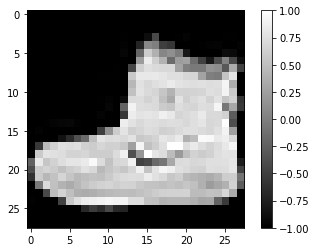

In [7]:
plt.imshow(train_x[0].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

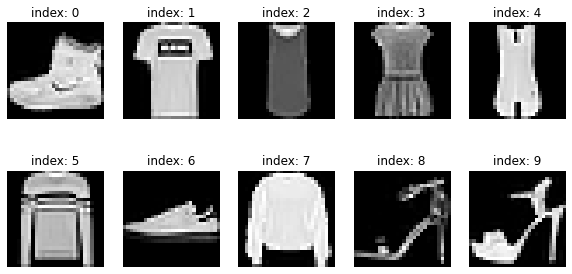

In [8]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [9]:
BUFFER_SIZE = 60000  # 전체 데이터를 섞기 위해 설정
BATCH_SIZE = 256  # 한 번에 학습할 데이터의 양

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

- `tf.data.Dataset` 모듈의 `from_tensor_slices()` 함수를 사용하면 리스트, 넘파이 또는 텐서플로우의 텐서 자료형에서 데이터셋을 만들 수 있다. 
- 위 코드는 `train_x`라는 넘파이 배열형 자료를 섞고, 이를 배치 사이즈에 따라 나누도록 한다. 
- 데이터가 잘 섞이게 하기 위해서는 버퍼 사이즈를 총 데이터 사이즈와 같거나 크게 설정하는 것이 좋다. 

## GAN(Generative Adversarial Network)
GAN에는 두 가지 네트워크가 있다. 
- `생성자(Generator)`는 아무 의미 없는 랜덤 노이즈로부터 신경망에서의 연산을 통해 이미지 형상의 벡터를 생성해낸다. 즉, 무에서 유를 창조하는 것과 같다. 
- `판별자(Discriminator)`는 기존에 있던 진짜 이미지와 생성자가 만들어낸 이미지를 입력받아 각 이미지가 Real인지, Fake인지에 대한 판단 정도를 실수값으로 출력한다. 

In [10]:
def make_generator_model():
    
    # Start
    model = tf.keras.Sequential()
    
    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))
    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    return model

- 여기서 가장 중요한 레이어는 `Conv2DTranspose` 레이어다. 이는 일반적인 `Conv2D`와 반대로 이미지 사이즈를 넓혀주는 층이다. 
- 이 모델에서는 세 번의 `Conv2DTranspose` 층을 이용해 `(7, 7, 256)` -> `(14, 14, 64)` -> `(28, 28, 1)` 순으로 이미지를 키워나간다.
- `BatchNormalization` 레이어는 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화해준다. 또한 중간층들의 활성화 함수는 모두 `LeakyReLU`를 사용했다. 
- 마지막 층에는 활성화 함수로 `tanh`를 사용하는데, 이는 우리가 [-1, 1] 이내의 값으로 픽셀 값을 정규화시켰던 데이터셋과 동일하게 하기 위함이다. 

In [11]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

- 모델이 만들어졌으니, shape=(1, 100)의 형상을 갖는 랜덤 노이즈 벡터를 생성해 결과물을 만들어보자. 
- `tf.random.normal`을 이용하면 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만들 수 있다. 

In [12]:
noise = tf.random.normal([1, 100])

In [13]:
# 텐서플로우 2.0 이후 버전에서는 레이어와 모델에 call 메서드를 구현해 놓기 때문에,
# 방금 만들어진 생성자 모델에 입력값으로 노잊르르 넣고 바로 모델을 호출하면 간단히 결과 이미지가 생성된다. 
# 지금은 학습하는 중이 아니기 때문에 training=False를 설정해야 한다. 
# Batch Normalization 레이어는 훈련 시기와 추론(inference) 시기의 행동이 다르기 때문에 training=False를 줘야 올바른 결과를 얻을 수 있다. 
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

- `[1, 28, 28, 1]` 사이즈의 이미지가 잘 생성되었다. 첫 번째 1은 batch_size, 그 뒤로는 (28, 28, 1) 사이즈 이미지를 의미한다. 

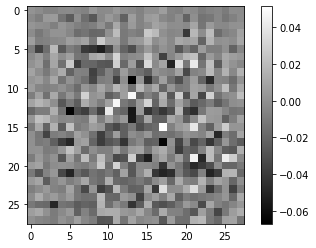

In [14]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

- -1과 1 사이의 값에서 적당히 잘 생성되었다. 아직은 모델이 전혀 학습하지 않은 상태이기 때문에 아무런 의미 없는 노이즈 이미지가 생성되었다. 

In [15]:
def make_discriminator_model():
    
    # Start
    model = tf.keras.Sequential()
    
    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third: Flatten Layer
    model.add(layers.Flatten())
    
    # Fourth: Dense Layer
    model.add(layers.Dense(1))
    
    return model

- `Conv2DTranspose` 층을 이용해 이미지를 키워나갔던 생성자와 반대로, 판별자는 `Conv2D` 층으로 이미지의 크기를 점점 줄여나간다. 
- 첫 번째 `Conv2D` 층에서 입력된 `[28, 28, 1]` 사이즈의 이미지는 `(28, 28, 1)` -> `(14, 14, 64)` -> `(7, 7, 128)` 까지 줄어들게 된다.
- 마지막에는 `Flatten` 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 7x7x128=6272, 즉 (1, 6272) 형상의 벡터로 변환한다. 
- 이는 생성자의 `Reshape` 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할을 한다. 
- 1차원 벡터로 변환한 후에는 마지막 `Dense` 레이어를 거쳐 단 하나의 값을 출력한다. 

In [16]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [17]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00265014]], dtype=float32)>

- 텐서플로우의 텐서 형태로 출력되었다. 이 값 또한 아직은 아무런 의미가 없을 것이다. 

## 손실함수 (Loss function)
GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용한다. 교차 엔트로피는 분류 모델을 설계할 때 많이 사용했던 손실함수로, 점점 가까워지기 시작하는 두 값이 얼마나 큰 차이가 있는지 정량적으로 계산할 때 많이 쓰인다. 특히 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로, 이진 교차 엔트로피(binary cross entropy)를 사용할 것이다. 

In [18]:
# 교차 엔트로피를 계산하기 위해 입력할 값은 판별자가 판별한 값인데, 판별자 모델의 마지막 레이어에는 값을 정규화시키는 sigmoid나 tanh 같은 활성화 함수가 없다. 
# 즉, 판별자가 출력하는 값은 범위가 정해지지 않아 모든 실수값을 가질 수 있다. 
# tf.keras.losses의 BinaryCrossentropy 클래스는 기본적으로 인풋값이 0에서 1사이에 분포하는 확률값이라 가정한다. 
# 따라서 from_logits를 True로 설정해줘야 BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 정규화하고 계산할 수 있다. 

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### generator_loss
- `generator_loss`는 `fake_output`이 1에 가까워지기 바라므로, `tf.ones_like`와의 교차 엔트로피값을 계산하면 된다.

In [19]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### discriminator_loss
- 반면, `discriminator_loss`는 `real_output` 값은 1에 가까워지기를, `fake_output` 값은 0에 가까워지기를 바라므로 두 가지 loss 값을 모두 계산한다. 

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### discriminator accuarcy
- 판별자가 real_output, fake_output을 얼마나 정확히 판별하는지 accuarcy를 계산해 보는 것도 GAN의 학습에서 매우 중요하다. 
- 판별자가 real_output과 fake_output을 accuracy가 1에 가깝게 정확히 판별해 낸다해도 좋은 것은 아니다. 이 경우 생성자가 만들어내는 fake_output이 real_output과 차이가 많이 나기 때문에 매우 쉽게 판별해내고 있다는 뜻이기 때문이다. 
- 따라서, real accuracy와 fake accuracy가 초반에는 1에 가깝게 나오다가, 서서히 낮아져 둘 다 0.5에 가까워지는 것이 이상적이다. 

In [21]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

## 최적화 함수 (optimizer)
- 생성자와 구분자는 따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어줘야 한다. 

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [23]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

- 매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인해보자. 
- 샘플은 한 번에 16장으로, 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즐르 만들어야 한다. 
- 즉, 100차원의 노이즈를 총 16개, `(16, 100)` 형상의 벡터를 만들어 두자. 

## 훈련 과정 설계
`@tf.function` 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수있는 타입으로 자동 변환된다. 

In [24]:
@tf.function
def train_step(images):  # (1) 입력 데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  # (2) 생성자 입력 노이즈
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  # (3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  # (4) generated_image 생성
        
        # (5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        # (6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        # (7) accuarcy 계산
        real_accuracy, fake_accuarcy = discriminator_accuracy(real_output, fake_output)
        
    # (8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # (9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuarcy  # (10) 리턴 값

In [25]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    
    predictions = model(sample_seeds, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis=('off')
        
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [26]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6. # matlab 차트의 기본 크기를 15, 6으로 지정

def draw_train_history(history, epoch):
    # summarize history for loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model_loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')
    
    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장한다. 
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [27]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

- 정기적으로 모델을 저장하기 위한 checkpoint 생성
- `tf.train.Checkpoint`를 활용하면 매번 모델을 직접 저장해 주지 않아도, 코드 한 줄로 빠르고 편하게 버전을 관리할 수 있다. 
- checkpoint에는 optimizer와 생성자, 판별자를 모두 넣어 저장한다. 정확히는 생성자와 판별자가 학습한 모델 가중치를 저장한다. 

In [28]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [29]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

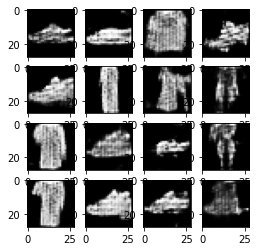

Time for training : 952 sec


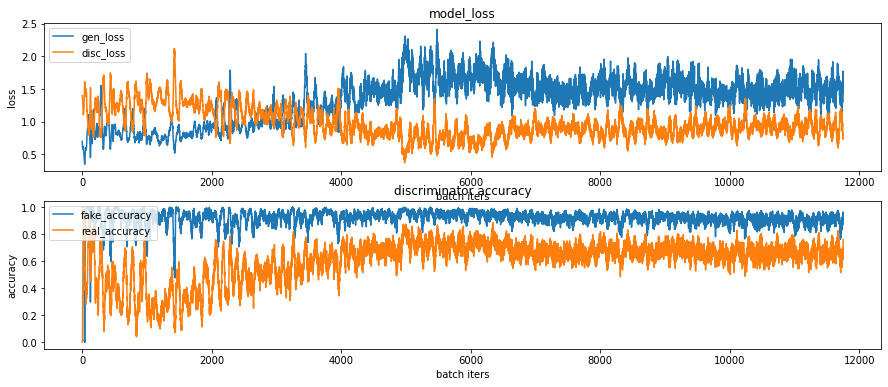

CPU times: user 9min 38s, sys: 1min 18s, total: 10min 57s
Wall time: 15min 53s


In [30]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

## 학습과정 시각화

In [31]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1071367 Feb  8 03:36 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif
